In [1]:
!pip3 install pyro-ppl

     |████████████████████████████████| 713 kB 5.5 MB/s 


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score
from pyro.nn import PyroModule, PyroSample
from pyro.infer.autoguide import AutoNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

In [12]:
class NN(nn.Module):
  #deterministic neural network
    def __init__(self, i, h, o):
        super(NN, self).__init__()
        #define the input layer
        self.fc1 = nn.Linear(i, h)
        #define the hidden layer
        self.fc2 = nn.Linear(h, o)
        
    def forward(self, x):
        #apply rely activation 
        res = torch.relu(self.fc1(x))
        res = torch.relu(self.fc2(res))

        return res

In [13]:
def train_det(model, X_train, Y_train, X_test, Y_test, lr, epochs, batch):  
    #define the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    #define the criterion loss for multiclass classification
    criterion = torch.nn.CrossEntropyLoss()

    #create batches torch for training and test sets
    b_x_train, b_y_train = torch.split(X_train, batch), torch.split(Y_train, batch)
    b_x_test, b_y_test = torch.split(X_test, batch), torch.split(Y_test, batch)

    #create a list of train losses to plot
    losses_train = []
    #create a list of train accuracies to plot
    scores_train = []
    #create a list of test accuracies to plot
    scores_test = []
    for epoch in range(epochs):
      #iterate through epoches
        train_loss = 0
        no_batches = len(b_x_train)
        for i in range(no_batches):
            #iterate through batches
            optimizer.zero_grad() 
            #get the output of the model for the current batch
            output = model(b_x_train[i])
            target = torch.tensor(b_y_train[i], dtype=torch.long)
            #calculate the loss of the batch
            actual_loss = criterion(output, target)
            #add to the total loss
            train_loss += actual_loss

            actual_loss.backward()
            optimizer.step()
        
        #calculate train loss
        train_loss = train_loss / len(X_train)
        train_loss = train_loss.item()
        losses_train.append(train_loss)

        actual_predictions = []
        with torch.no_grad():
          #iterate through train batches
            for batch in b_x_train:
              #convert the probability of the softmax function to the actual class
                predicted_labels = model(batch)
                predicted_labels = torch.argmax(torch.softmax(predicted_labels, dim=-1), dim=-1).detach().numpy()

                for label in predicted_labels:
                  actual_predictions.append(label)

            train_score = accuracy_score(Y_train.detach().numpy(), actual_predictions)
        #calculate the train accuracy
        train_score = train_score.item()
        scores_train.append(train_score)

        actual_predictions = []
        with torch.no_grad():
            #iterate through test batches
            for batch in b_x_test:
                predicted_labels = model(batch)
                #convert the probability of the softmax function to the actual class
                predicted_labels = torch.argmax(torch.softmax(predicted_labels, dim=-1), dim=-1).detach().numpy()

                for label in predicted_labels:
                  actual_predictions.append(label)

            test_score = accuracy_score(Y_test.detach().numpy(), actual_predictions)
        #calculate the test accuracy
        test_score = test_score.item()
        scores_test.append(test_score)
        

        print("epoch: {}, train loss: {}, train acc: {}, test acc: {}".format(epoch, train_loss, train_score, test_score))

    #return the train losses and train and test accuracies
    return np.asarray(losses_train), np.asarray(scores_train), np.asarray(scores_test)


In [14]:
#create a new dataset with 7000 samples and 6 classes
X, y = make_classification(n_samples=7000, n_features=30, n_informative=12, n_redundant=4, n_classes=6)
#split the dataset into 80% training set and 20% test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#convert them into torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [15]:
#define the model
model = NN(i=30,h=32,o=6)

#train the model
train_losses, score_train, score_test = train_det(model, X_train, y_train, X_test, y_test, lr=0.005, epochs=150, batch=64)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 0, train loss: 0.020961347967386246, train acc: 0.6380357142857143, test acc: 0.6278571428571429
epoch: 1, train loss: 0.014150927774608135, train acc: 0.7126785714285714, test acc: 0.6942857142857143
epoch: 2, train loss: 0.011983995325863361, train acc: 0.7585714285714286, test acc: 0.7142857142857143


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 3, train loss: 0.010708091780543327, train acc: 0.7869642857142857, test acc: 0.7285714285714285
epoch: 4, train loss: 0.009860504418611526, train acc: 0.8041071428571429, test acc: 0.745
epoch: 5, train loss: 0.009234251454472542, train acc: 0.81875, test acc: 0.7557142857142857


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 6, train loss: 0.008766723796725273, train acc: 0.8257142857142857, test acc: 0.7592857142857142
epoch: 7, train loss: 0.008364366367459297, train acc: 0.8360714285714286, test acc: 0.7657142857142857
epoch: 8, train loss: 0.008071111515164375, train acc: 0.8403571428571428, test acc: 0.7692857142857142


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 9, train loss: 0.007838990539312363, train acc: 0.8441071428571428, test acc: 0.7692857142857142
epoch: 10, train loss: 0.007638064678758383, train acc: 0.8489285714285715, test acc: 0.775
epoch: 11, train loss: 0.007468865253031254, train acc: 0.8523214285714286, test acc: 0.7764285714285715


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 12, train loss: 0.007336953189224005, train acc: 0.8528571428571429, test acc: 0.775
epoch: 13, train loss: 0.007209740579128265, train acc: 0.8542857142857143, test acc: 0.775
epoch: 14, train loss: 0.007110618054866791, train acc: 0.8564285714285714, test acc: 0.7771428571428571


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 15, train loss: 0.007027886807918549, train acc: 0.8594642857142857, test acc: 0.7721428571428571
epoch: 16, train loss: 0.006929696537554264, train acc: 0.8610714285714286, test acc: 0.7757142857142857
epoch: 17, train loss: 0.00686383293941617, train acc: 0.8619642857142857, test acc: 0.7757142857142857


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 18, train loss: 0.006789729930460453, train acc: 0.8644642857142857, test acc: 0.7814285714285715
epoch: 19, train loss: 0.006721721962094307, train acc: 0.8657142857142858, test acc: 0.7792857142857142
epoch: 20, train loss: 0.006654287688434124, train acc: 0.8658928571428571, test acc: 0.785


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 21, train loss: 0.006585846655070782, train acc: 0.8680357142857142, test acc: 0.785
epoch: 22, train loss: 0.006521114148199558, train acc: 0.86875, test acc: 0.7807142857142857
epoch: 23, train loss: 0.006455777212977409, train acc: 0.8701785714285715, test acc: 0.7807142857142857


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 24, train loss: 0.006376978941261768, train acc: 0.8717857142857143, test acc: 0.7821428571428571
epoch: 25, train loss: 0.006332681514322758, train acc: 0.8725, test acc: 0.7814285714285715
epoch: 26, train loss: 0.006274724844843149, train acc: 0.8733928571428572, test acc: 0.7821428571428571


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 27, train loss: 0.006221449933946133, train acc: 0.8733928571428572, test acc: 0.7807142857142857
epoch: 28, train loss: 0.006185442209243774, train acc: 0.8730357142857142, test acc: 0.7835714285714286
epoch: 29, train loss: 0.006136497016996145, train acc: 0.87625, test acc: 0.785


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 30, train loss: 0.006099312100559473, train acc: 0.8789285714285714, test acc: 0.7828571428571428
epoch: 31, train loss: 0.006067092530429363, train acc: 0.8785714285714286, test acc: 0.7835714285714286
epoch: 32, train loss: 0.0060232048854231834, train acc: 0.8798214285714285, test acc: 0.7828571428571428


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 33, train loss: 0.006001908332109451, train acc: 0.8817857142857143, test acc: 0.7814285714285715
epoch: 34, train loss: 0.005972379352897406, train acc: 0.8823214285714286, test acc: 0.785
epoch: 35, train loss: 0.005941924173384905, train acc: 0.8823214285714286, test acc: 0.7835714285714286


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 36, train loss: 0.00591406412422657, train acc: 0.8808928571428571, test acc: 0.7828571428571428
epoch: 37, train loss: 0.005890597589313984, train acc: 0.8828571428571429, test acc: 0.7821428571428571
epoch: 38, train loss: 0.005855225957930088, train acc: 0.8819642857142858, test acc: 0.7835714285714286


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 39, train loss: 0.005839471239596605, train acc: 0.8828571428571429, test acc: 0.7821428571428571
epoch: 40, train loss: 0.005828178953379393, train acc: 0.88125, test acc: 0.7828571428571428
epoch: 41, train loss: 0.005814848467707634, train acc: 0.88375, test acc: 0.7821428571428571


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 42, train loss: 0.005785507615655661, train acc: 0.8842857142857142, test acc: 0.7835714285714286
epoch: 43, train loss: 0.005768562667071819, train acc: 0.8830357142857143, test acc: 0.7814285714285715
epoch: 44, train loss: 0.005763873923569918, train acc: 0.8853571428571428, test acc: 0.7857142857142857


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 45, train loss: 0.005738258361816406, train acc: 0.8833928571428571, test acc: 0.7842857142857143
epoch: 46, train loss: 0.005718450527638197, train acc: 0.8860714285714286, test acc: 0.7885714285714286
epoch: 47, train loss: 0.005699105095118284, train acc: 0.8855357142857143, test acc: 0.7842857142857143


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 48, train loss: 0.005680016707628965, train acc: 0.8871428571428571, test acc: 0.7878571428571428
epoch: 49, train loss: 0.00565929664298892, train acc: 0.8876785714285714, test acc: 0.7885714285714286
epoch: 50, train loss: 0.005644540768116713, train acc: 0.8867857142857143, test acc: 0.7907142857142857


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 51, train loss: 0.005632814485579729, train acc: 0.8873214285714286, test acc: 0.7892857142857143
epoch: 52, train loss: 0.005619758274406195, train acc: 0.8866071428571428, test acc: 0.7871428571428571
epoch: 53, train loss: 0.005603550933301449, train acc: 0.88625, test acc: 0.7871428571428571


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 54, train loss: 0.005589641630649567, train acc: 0.8875, test acc: 0.7857142857142857
epoch: 55, train loss: 0.005576450377702713, train acc: 0.8873214285714286, test acc: 0.7871428571428571
epoch: 56, train loss: 0.005571100860834122, train acc: 0.8873214285714286, test acc: 0.7842857142857143


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 57, train loss: 0.005548746790736914, train acc: 0.8875, test acc: 0.7864285714285715
epoch: 58, train loss: 0.005537304095923901, train acc: 0.8898214285714285, test acc: 0.7878571428571428
epoch: 59, train loss: 0.005520549602806568, train acc: 0.8891071428571429, test acc: 0.7864285714285715


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 60, train loss: 0.0055113136768341064, train acc: 0.8882142857142857, test acc: 0.7885714285714286
epoch: 61, train loss: 0.005499363411217928, train acc: 0.8894642857142857, test acc: 0.7878571428571428
epoch: 62, train loss: 0.005489672068506479, train acc: 0.8885714285714286, test acc: 0.785


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 63, train loss: 0.005475499667227268, train acc: 0.8894642857142857, test acc: 0.7878571428571428
epoch: 64, train loss: 0.00545366108417511, train acc: 0.8905357142857143, test acc: 0.7928571428571428
epoch: 65, train loss: 0.00545782083645463, train acc: 0.8908928571428572, test acc: 0.7907142857142857


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 66, train loss: 0.005450233351439238, train acc: 0.8889285714285714, test acc: 0.79
epoch: 67, train loss: 0.005432056728750467, train acc: 0.8903571428571428, test acc: 0.79
epoch: 68, train loss: 0.005429829470813274, train acc: 0.8910714285714286, test acc: 0.7892857142857143


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 69, train loss: 0.005416584201157093, train acc: 0.8919642857142858, test acc: 0.7914285714285715
epoch: 70, train loss: 0.005398646462708712, train acc: 0.8925, test acc: 0.7885714285714286
epoch: 71, train loss: 0.005391164217144251, train acc: 0.8901785714285714, test acc: 0.7871428571428571


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 72, train loss: 0.005382365547120571, train acc: 0.8921428571428571, test acc: 0.7864285714285715
epoch: 73, train loss: 0.005364082287997007, train acc: 0.8921428571428571, test acc: 0.7871428571428571
epoch: 74, train loss: 0.005354771390557289, train acc: 0.89375, test acc: 0.7871428571428571


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 75, train loss: 0.005334576591849327, train acc: 0.8935714285714286, test acc: 0.7871428571428571
epoch: 76, train loss: 0.005326412618160248, train acc: 0.8942857142857142, test acc: 0.7878571428571428
epoch: 77, train loss: 0.0053244889713823795, train acc: 0.89375, test acc: 0.7878571428571428


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 78, train loss: 0.005311335436999798, train acc: 0.89375, test acc: 0.7857142857142857
epoch: 79, train loss: 0.005310666747391224, train acc: 0.8946428571428572, test acc: 0.79
epoch: 80, train loss: 0.005294242408126593, train acc: 0.895, test acc: 0.7885714285714286


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 81, train loss: 0.005293451715260744, train acc: 0.8957142857142857, test acc: 0.7878571428571428
epoch: 82, train loss: 0.005279687233269215, train acc: 0.8951785714285714, test acc: 0.7835714285714286
epoch: 83, train loss: 0.005276876036077738, train acc: 0.8948214285714285, test acc: 0.7835714285714286


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 84, train loss: 0.005266221705824137, train acc: 0.8958928571428572, test acc: 0.7821428571428571
epoch: 85, train loss: 0.005265474785119295, train acc: 0.895, test acc: 0.7857142857142857
epoch: 86, train loss: 0.0052512027323246, train acc: 0.8958928571428572, test acc: 0.7821428571428571


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 87, train loss: 0.005247419700026512, train acc: 0.8960714285714285, test acc: 0.785
epoch: 88, train loss: 0.005241889040917158, train acc: 0.8969642857142858, test acc: 0.785
epoch: 89, train loss: 0.005225049797445536, train acc: 0.8967857142857143, test acc: 0.7871428571428571


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 90, train loss: 0.005222119390964508, train acc: 0.8967857142857143, test acc: 0.785
epoch: 91, train loss: 0.0052175624296069145, train acc: 0.8978571428571429, test acc: 0.7878571428571428
epoch: 92, train loss: 0.005203151609748602, train acc: 0.8967857142857143, test acc: 0.7871428571428571


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 93, train loss: 0.005191102158278227, train acc: 0.8989285714285714, test acc: 0.79
epoch: 94, train loss: 0.005180491134524345, train acc: 0.8985714285714286, test acc: 0.7885714285714286
epoch: 95, train loss: 0.005181916523724794, train acc: 0.8998214285714285, test acc: 0.7914285714285715


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 96, train loss: 0.00516071543097496, train acc: 0.8982142857142857, test acc: 0.7907142857142857
epoch: 97, train loss: 0.005160758271813393, train acc: 0.8994642857142857, test acc: 0.7928571428571428
epoch: 98, train loss: 0.005160395987331867, train acc: 0.8996428571428572, test acc: 0.7928571428571428


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 99, train loss: 0.00514526991173625, train acc: 0.9010714285714285, test acc: 0.7942857142857143
epoch: 100, train loss: 0.0051569207571446896, train acc: 0.9016071428571428, test acc: 0.795
epoch: 101, train loss: 0.005141361616551876, train acc: 0.9008928571428572, test acc: 0.795


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 102, train loss: 0.005136003717780113, train acc: 0.9003571428571429, test acc: 0.7942857142857143
epoch: 103, train loss: 0.005129403434693813, train acc: 0.9016071428571428, test acc: 0.7957142857142857
epoch: 104, train loss: 0.005134629085659981, train acc: 0.9007142857142857, test acc: 0.7942857142857143


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 105, train loss: 0.00512074725702405, train acc: 0.9023214285714286, test acc: 0.7971428571428572
epoch: 106, train loss: 0.005121471825987101, train acc: 0.9021428571428571, test acc: 0.7935714285714286
epoch: 107, train loss: 0.005117001477628946, train acc: 0.9025, test acc: 0.7971428571428572


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 108, train loss: 0.00511315930634737, train acc: 0.9023214285714286, test acc: 0.795
epoch: 109, train loss: 0.005103280767798424, train acc: 0.9014285714285715, test acc: 0.795
epoch: 110, train loss: 0.005093323066830635, train acc: 0.9032142857142857, test acc: 0.7957142857142857


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 111, train loss: 0.005102083552628756, train acc: 0.9019642857142857, test acc: 0.7971428571428572
epoch: 112, train loss: 0.005087638273835182, train acc: 0.9021428571428571, test acc: 0.8
epoch: 113, train loss: 0.005085071083158255, train acc: 0.9017857142857143, test acc: 0.7971428571428572


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 114, train loss: 0.005077782552689314, train acc: 0.90125, test acc: 0.7992857142857143
epoch: 115, train loss: 0.005070121958851814, train acc: 0.9025, test acc: 0.7957142857142857
epoch: 116, train loss: 0.005056568421423435, train acc: 0.9005357142857143, test acc: 0.7957142857142857


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 117, train loss: 0.0050645130686461926, train acc: 0.9, test acc: 0.7992857142857143
epoch: 118, train loss: 0.005064401775598526, train acc: 0.90125, test acc: 0.7992857142857143
epoch: 119, train loss: 0.0050544883124530315, train acc: 0.8998214285714285, test acc: 0.7971428571428572


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 120, train loss: 0.005052055697888136, train acc: 0.90125, test acc: 0.7957142857142857
epoch: 121, train loss: 0.005049210507422686, train acc: 0.9008928571428572, test acc: 0.795
epoch: 122, train loss: 0.0050581046380102634, train acc: 0.9, test acc: 0.7978571428571428


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 123, train loss: 0.005050720646977425, train acc: 0.9, test acc: 0.7957142857142857
epoch: 124, train loss: 0.005046486388891935, train acc: 0.9008928571428572, test acc: 0.7971428571428572
epoch: 125, train loss: 0.005041489377617836, train acc: 0.9007142857142857, test acc: 0.8


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 126, train loss: 0.005042740143835545, train acc: 0.9010714285714285, test acc: 0.7985714285714286
epoch: 127, train loss: 0.0050384001806378365, train acc: 0.9, test acc: 0.7935714285714286
epoch: 128, train loss: 0.005039798095822334, train acc: 0.9007142857142857, test acc: 0.7964285714285714


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 129, train loss: 0.005032411310821772, train acc: 0.9008928571428572, test acc: 0.7985714285714286
epoch: 130, train loss: 0.005033940076828003, train acc: 0.90125, test acc: 0.7978571428571428
epoch: 131, train loss: 0.005031052511185408, train acc: 0.9014285714285715, test acc: 0.7992857142857143


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 132, train loss: 0.005021813791245222, train acc: 0.90125, test acc: 0.8035714285714286
epoch: 133, train loss: 0.005028248764574528, train acc: 0.90125, test acc: 0.8035714285714286
epoch: 134, train loss: 0.005028281360864639, train acc: 0.9005357142857143, test acc: 0.8007142857142857


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 135, train loss: 0.005015452392399311, train acc: 0.8996428571428572, test acc: 0.8028571428571428
epoch: 136, train loss: 0.005011226516216993, train acc: 0.9005357142857143, test acc: 0.8028571428571428
epoch: 137, train loss: 0.005006158724427223, train acc: 0.8998214285714285, test acc: 0.8028571428571428


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 138, train loss: 0.005004908889532089, train acc: 0.9005357142857143, test acc: 0.8014285714285714
epoch: 139, train loss: 0.005003413651138544, train acc: 0.8991071428571429, test acc: 0.8035714285714286
epoch: 140, train loss: 0.004999322816729546, train acc: 0.8994642857142857, test acc: 0.8028571428571428


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 141, train loss: 0.004992091562598944, train acc: 0.8994642857142857, test acc: 0.8021428571428572
epoch: 142, train loss: 0.004990443587303162, train acc: 0.8996428571428572, test acc: 0.8
epoch: 143, train loss: 0.004979872610419989, train acc: 0.8991071428571429, test acc: 0.8014285714285714


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 144, train loss: 0.0049838232807815075, train acc: 0.9008928571428572, test acc: 0.8014285714285714
epoch: 145, train loss: 0.0049732341431081295, train acc: 0.9003571428571429, test acc: 0.7985714285714286
epoch: 146, train loss: 0.004969229456037283, train acc: 0.9007142857142857, test acc: 0.7992857142857143


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 147, train loss: 0.004966605920344591, train acc: 0.9019642857142857, test acc: 0.7992857142857143
epoch: 148, train loss: 0.004957337398082018, train acc: 0.9007142857142857, test acc: 0.7985714285714286
epoch: 149, train loss: 0.004952668212354183, train acc: 0.9010714285714285, test acc: 0.7964285714285714


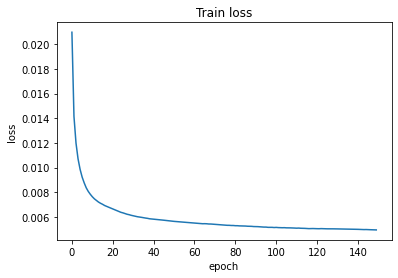

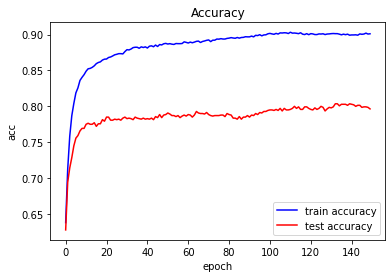

In [16]:
plt.plot(train_losses)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title('Train loss')
plt.show()

plt.plot(score_train, '-b', label='train accuracy')
plt.plot(score_test, '-r', label='test accuracy')
plt.title('Accuracy')
plt.xlabel("epoch")
plt.ylabel("acc")
plt.legend()
plt.show()

In [17]:
#@title Bayesian Neural Network
class BayesianNeuralNetwork(PyroModule):
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        #define the first layer
        self.fc1 = PyroModule[nn.Linear](in_size, hidden_size)
        #define the second layer
        self.fc2 = PyroModule[nn.Linear](hidden_size, out_size)

        #assume a normal distributions for weight and bias
        self.fc1.weight = PyroSample(dist.Normal(0., 1.)
                                         .expand(self.fc1.weight.shape)
                                         .to_event(self.fc1.weight.dim()))
        self.fc1.bias = PyroSample(dist.Normal(0., 10.)
                                       .expand(self.fc1.bias.shape)
                                       .to_event(self.fc1.bias.dim()))
        
        self.fc2.weight = PyroSample(dist.Normal(0., 1.)
                                         .expand(self.fc2.weight.shape)
                                         .to_event(self.fc2.weight.dim()))
        self.fc2.bias = PyroSample(dist.Normal(0., 10.)
                                       .expand(self.fc2.bias.shape)
                                       .to_event(self.fc2.bias.dim()))
        
    
    def forward(self, x, y=None):
        #apply relu activation function
        x = F.relu(self.fc1(x))
        #apply softmax activation function
        x = F.log_softmax(self.fc2(x), dim=-1)

        #sample from the categorical distribution
        with pyro.plate('data', x.shape[0]):
            obs = pyro.sample('obs', dist.Categorical(logits=x), obs=y)
        
        return x

In [18]:
def train_bayesian(model, X_train, y_train, X_test, y_test, lr, epochs):  
  #clear parameters store
  pyro.clear_param_store()

  #define the criterion
  criterion = nn.BCELoss()
  #define the adam optimizer
  optimizer_bayes = pyro.optim.Adam({"lr": lr})

  svi = SVI(bayesian_model, guide, optimizer_bayes, loss=Trace_ELBO())

  #create a list of train losses to plot
  losses_bayes = []
  #create a list of train acc to plot
  train_scores = []

  #create a list of test losses to plot
  test_scores = []

  for epoch in range(0, epochs):
      loss = svi.step(X_train, y_train)
      #calculate the training loss
      train_loss = loss / len(X_train)
      losses_bayes.append(train_loss)

      # run on 250 samples extracted from the weights distributions 
      predictive = Predictive(bayesian_model, guide=guide, num_samples=250)
      pred_train_bayes = predictive(X_train)['obs'].median(dim=0)[0].int()
      train_score = (pred_train_bayes == y_train).float().mean()
      #calculate train accuracy
      train_scores.append(train_score)

      # run on 250 samples extracted from the weights distributions 
      pred_test_bayes = predictive(X_test)['obs'].median(dim=0)[0].int()
      test_score = (pred_test_bayes == y_test).float().mean()
      #calculate test accuracy
      test_scores.append(test_score)

      print("epoch: {}, train loss: {}, train acc: {}, test acc: {}".format(epoch, train_loss, train_score, test_score))
  #return the train losses and train and test accuracies
  return np.array(losses_bayes), np.array(train_scores), np.array(test_scores)

In [19]:
#define the model and the guide
bayesian_model = BayesianNeuralNetwork(30, 32, 6)
guide = AutoNormal(bayesian_model)

In [21]:
#train the bayesian neural network
train_losses, score_train, score_test = train_bayesian(bayesian_model, X_train, y_train, X_test, y_test, 0.05, 100)

epoch: 0, train loss: 2.306010757769857, train acc: 0.17125000059604645, test acc: 0.17428570985794067
epoch: 1, train loss: 2.6409026020765305, train acc: 0.19571428000926971, test acc: 0.18357142806053162
epoch: 2, train loss: 2.467588688986642, train acc: 0.17000000178813934, test acc: 0.167142853140831
epoch: 3, train loss: 2.624969930819103, train acc: 0.1971428543329239, test acc: 0.19142857193946838
epoch: 4, train loss: 2.3497184160777502, train acc: 0.25035715103149414, test acc: 0.24285714328289032
epoch: 5, train loss: 2.334884762082781, train acc: 0.25982141494750977, test acc: 0.2435714304447174
epoch: 6, train loss: 2.3371137292896, train acc: 0.29124999046325684, test acc: 0.28214284777641296
epoch: 7, train loss: 2.197596464412553, train acc: 0.3392857015132904, test acc: 0.3378571569919586
epoch: 8, train loss: 2.140543734601566, train acc: 0.3539285659790039, test acc: 0.35285714268684387
epoch: 9, train loss: 2.133510977455548, train acc: 0.3603571355342865, test acc

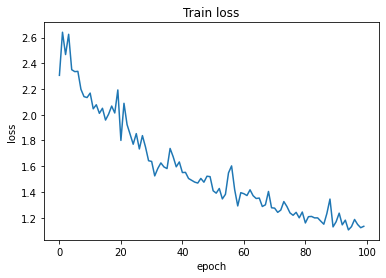

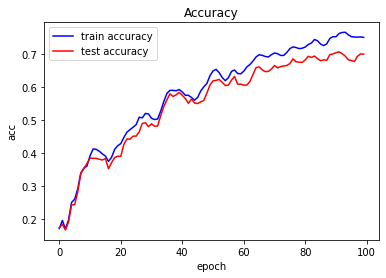

In [22]:
plt.plot(train_losses)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title('Train loss')
plt.show()

plt.plot(score_train, '-b', label='train accuracy')
plt.plot(score_test, '-r', label='test accuracy')
plt.title('Accuracy')
plt.xlabel("epoch")
plt.ylabel("acc")
plt.legend()
plt.show()

Conclusions: looking at the train loss and train/test accuracy plot, it can be easily seen that deep learning neural network works better than the bayesian neural network, but it seems that overfits. The overfit might be caused by the arhitecture of the neural network and the learning rate. However, looking at the bayesian neural network, it seems that greater number of epoches gets a better accuracy for the model looking at the plots and it also seems that it does not overfit as the deep learning model does. Unfortunately, it takes a lot of time to train so I limited the number of epoches to be equal to 100.